In [141]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from constants import FACE_ID_TRAIN_PATH, DATA_DIR
from Facenet.face_id_dataset import load_faces_in_batch

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd
import numpy as np

In [164]:
# preprocess train embedding dataframe
df_train_embeddings = pd.read_csv("embeddings/train_embeddings.csv")
# fix embeddings to np array
df_train_embeddings['embeddings'] = df_train_embeddings['embeddings'].apply(lambda x: np.array(x[1:-1].split(), dtype=np.float32))
# add person as column
df_train_embeddings['person'] = df_train_embeddings['identity'].apply(lambda p: Path(p).parent.name)
# add image name as column `img`
df_train_embeddings['img'] = df_train_embeddings['identity'].apply(lambda p: Path(p).name)
# drop whole path `identity` column
df_train_embeddings = df_train_embeddings.drop(['identity'], axis=1)

In [165]:
df_train_embeddings['person'].value_counts().describe()

count    125.000000
mean      54.624000
std       41.373917
min        5.000000
25%       30.000000
50%       49.000000
75%       68.000000
max      283.000000
Name: count, dtype: float64

# Split Train set to Validation

In [166]:
df = df_train_embeddings.copy()

In [167]:
# 1. get random people
np.random.seed(1710)
rand_people_index = np.random.randint(0, 124 + 1, 5)

rand_peple_mask = df['person'].apply(lambda x: int(x.split('_')[1]) in rand_people_index)

# make train set without it
train_df = df[~rand_peple_mask].copy()

# make validation set with it
val_df =  df[rand_peple_mask].copy()
val_df['gt'] = "doesn't_exist"
# remove it from train
rand_people_index

array([ 43, 121,  89, 113,  72])

foreach person sample percentage(0.2) of images for validation set

In [168]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [169]:
X = train_df.index
y = train_df['person']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in sss.split(X, y):
    v = train_df.iloc[val_idx].copy()
    v['gt'] = v['person']
    val_df = pd.concat([val_df, v])
    #
    train_df = train_df.iloc[train_idx].copy()

In [170]:
len(train_df['person'].unique()), len(val_df['person'].unique())

(120, 125)

by random select 5 people to go to validation set

In [171]:
# train_df['person'].value_counts().describe()
# val_df['person'].value_counts().describe()

In [172]:
len(val_df) / len(df) * 100

21.924428822495607

In [173]:
len(train_df) / len(df) * 100

78.07557117750439

In [174]:
set(val_df[val_df["person"] != "doesn't exist"]['person']) - set(train_df['person'])

{'person_113', 'person_121', 'person_43', 'person_72', 'person_89'}

In [175]:
# check no repeated item
val_df.set_index('img').join(train_df.set_index('img'), lsuffix='l').isna()['person'].all()

True

# Testing FaceNet on them

In [176]:
train_df_avg = train_df.groupby("person", as_index=False).agg({
    "embeddings": lambda x: np.mean(np.stack(x), axis=0)  # Average embeddings
})

In [177]:
def calculate_cosine_similarity(input_embeddings, df = train_df_avg, batch_size = 64):
    input_embeddings = input_embeddings.reshape(-1, 1) # embedding_size x 1
    input_embeddings /= np.linalg.norm(input_embeddings) # normalize embedding for cos calculations
    
    # store result in dataframe
    results_df = df.copy()
    cosine_similarities = np.zeros(len(df))
    # loop on df by batchs
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        
        batch_embeddings = np.vstack(batch['embeddings'].values) # batch_size x embedding_size
        batch_embeddings /= np.linalg.norm(batch_embeddings, axis=1, keepdims=True)
        
        result = np.dot(batch_embeddings, input_embeddings).reshape(-1,)
        cosine_similarities[i:i+batch_size] = result 
    
    results_df['cosine_similarity'] = cosine_similarities
    return results_df

In [178]:
get_img_of_person = lambda person_name: Image.open( next(iter(FACE_ID_TRAIN_PATH.rglob(f"{person_name}/*.jpg")))  )
get_img_by_name = lambda img_name: Image.open( next(iter(FACE_ID_TRAIN_PATH.rglob(img_name)))  )

def plot_sample_top_results(sample, ntop = 5):
    sample_img = get_img_by_name(sample['img'])
    results = calculate_cosine_similarity(sample['embeddings'], train_df_avg)
    
    top_n = results.sort_values(by='cosine_similarity').tail(ntop)
    # Plot 6 images (1 sample + 5 most similar)
    fig, axes = plt.subplots(1, ntop+1, figsize=(18, 5))

    # Plot the sample image
    axes[0].imshow(sample_img)
    axes[0].set_title(f"Sample Image, {sample['gt']}")
    axes[0].axis("off")

    # Plot the top 5 similar images
    for i, row in enumerate(top_n.iterrows()):
        img = get_img_of_person(row[1]['person'])
        
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"Sim: {row[1]['cosine_similarity']:.2f}, {row[1]['person']}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()
    
    return results



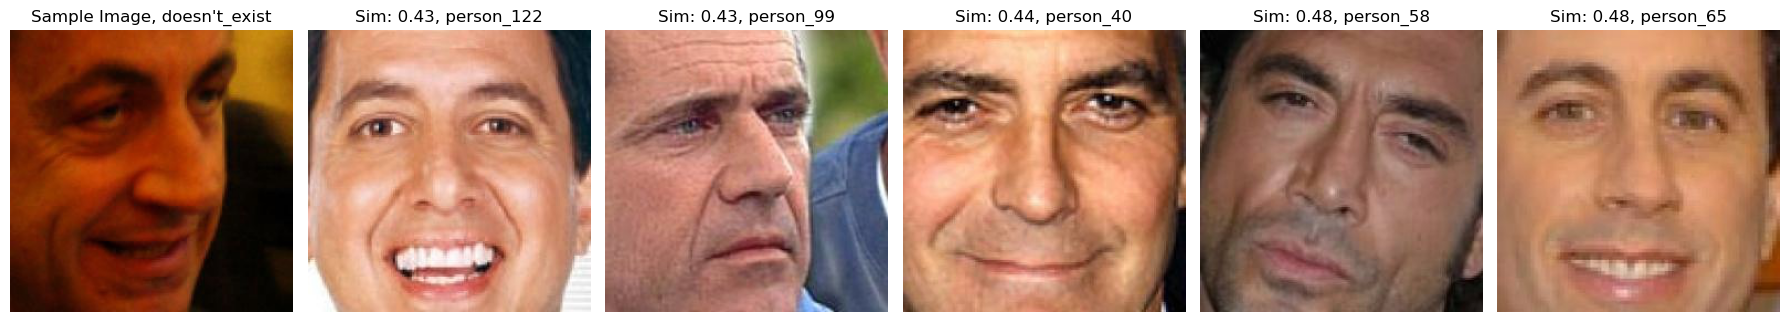

In [179]:
r = plot_sample_top_results(val_df.iloc[0])

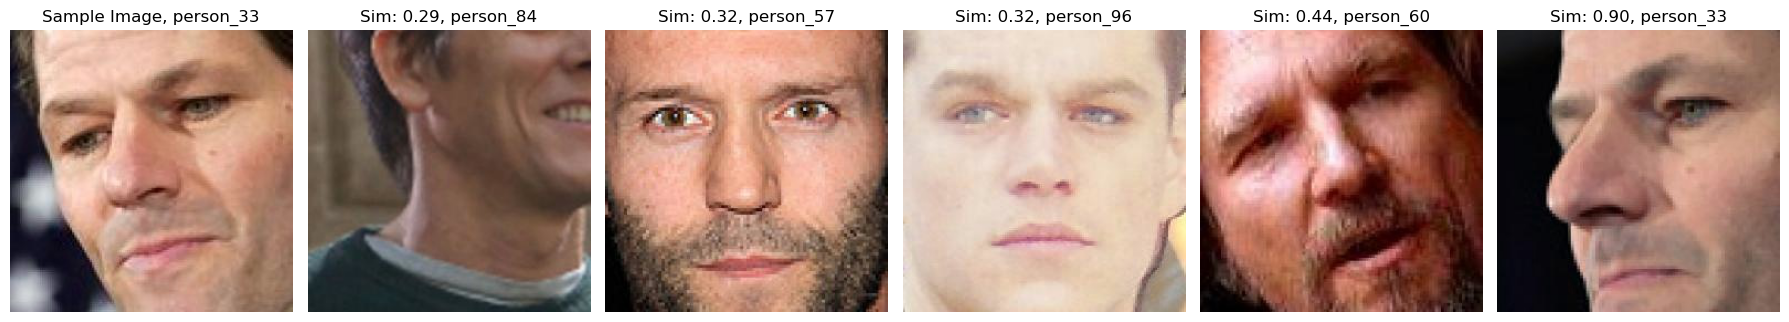

In [180]:
r = plot_sample_top_results(val_df.iloc[205])

In [181]:
# [ 43, 121,  89, 113,  72]

# Calculate Accuracy for Validation set

In [160]:
from sklearn.metrics import accuracy_score

In [184]:
val_df = val_df.reset_index(drop=True)
y = list(val_df['gt'].values)

In [189]:
thresholds = [0.45, 0.5, 0.55, 0.6, 0.65]
results = []

for th in tqdm(thresholds):
    y_pred = []
    for i, row in tqdm(val_df.iterrows(), total=len(val_df)):
        top_similar = calculate_cosine_similarity(row['embeddings'], batch_size=512).nlargest(1, 'cosine_similarity').iloc[0]
        if top_similar['cosine_similarity'] >= th:
            y_pred.append(top_similar['person'])
        else:
            y_pred.append("doesn't_exist")

    result = {'th': th, 'acc': accuracy_score(y, y_pred), 'y_pred': y_pred}
    results.append(result)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

  0%|          | 0/1497 [00:00<?, ?it/s]

In [191]:
pd.DataFrame(results).sort_values(by='acc', ascending=False)

th       acc                                             y_pred
2  0.55  0.945224  [doesn't_exist, doesn't_exist, doesn't_exist, ...
3  0.60  0.940548  [doesn't_exist, doesn't_exist, doesn't_exist, ...
1  0.50  0.939880  [doesn't_exist, doesn't_exist, doesn't_exist, ...
0  0.45  0.915832  [person_65, person_99, doesn't_exist, person_6...
4  0.65  0.915164  [doesn't_exist, doesn't_exist, doesn't_exist, ...

## Investigate Errors

In [219]:
best_y_pred = pd.DataFrame(results).sort_values(by='acc', ascending=False).iloc[0]['y_pred']

misclassified_indices = [i for i, (true, pred) in enumerate(zip(y, best_y_pred)) if true != pred]
misclassified_samples = val_df.loc[misclassified_indices]
# accuracy_score(y, best_y_pred) * len(y)

In [220]:
val_df.reset_index(drop=True)

embeddings      person       img  \
0     [0.010627606, 0.049963407, 0.0369003, -0.00062...  person_113  1168.jpg   
1     [0.040022403, 0.09242625, 0.077681474, 0.03318...  person_113  1169.jpg   
2     [0.017539812, 0.043478295, 0.028692516, -0.030...  person_113  1170.jpg   
3     [0.032139383, 0.082812265, 0.015788997, 0.0109...  person_113  1171.jpg   
4     [0.023707531, 0.057327528, -0.0022085132, -0.0...  person_113  1172.jpg   
...                                                 ...         ...       ...   
1492  [-0.011945121, -0.004391218, 0.066598274, -0.0...   person_22  3219.jpg   
1493  [0.00837738, -0.052256342, -0.057559546, -0.00...   person_34  4039.jpg   
1494  [-0.028591437, 0.04327407, -0.02897144, -0.132...   person_90  8617.jpg   
1495  [0.011054963, 0.086620905, 0.034640227, -0.016...  person_124  2262.jpg   
1496  [0.031764958, -0.006003416, 0.0006978831, -0.0...   person_21  3141.jpg   

                 gt  
0     doesn't_exist  
1     doesn't_exist  
2     doesn't_exist  
3     doesn't_exist  
4     doesn't_exist  
...             ...  
1492      person_22  
1493      person_34  
1494      person_90  
1495     person_124  
1496      person_21  

[1497 rows x 4 columns]

In [226]:
misclassified_samples['gt'].value_counts()

gt
doesn't_exist    27
person_45         4
person_78         3
person_117        3
person_90         3
person_9          2
person_109        2
person_63         2
person_105        2
person_83         2
person_70         2
person_16         2
person_57         2
person_7          1
person_31         1
person_41         1
person_62         1
person_106        1
person_112        1
person_71         1
person_52         1
person_24         1
person_75         1
person_51         1
person_30         1
person_96         1
person_40         1
person_53         1
person_66         1
person_110        1
person_17         1
person_80         1
person_69         1
person_119        1
person_23         1
person_61         1
person_35         1
person_124        1
person_19         1
Name: count, dtype: int64

In [222]:
(misclassified_samples['gt'] != "doesn't_exist").sum()

55

In [223]:
# misclassified_samples['gt'].value_counts()
misclassified_samples['gt']

16      doesn't_exist
24      doesn't_exist
26      doesn't_exist
63      doesn't_exist
72      doesn't_exist
            ...      
1349       person_117
1351        person_78
1372        person_19
1428       person_105
1463       person_117
Name: gt, Length: 82, dtype: object

doesn't_exist person_65


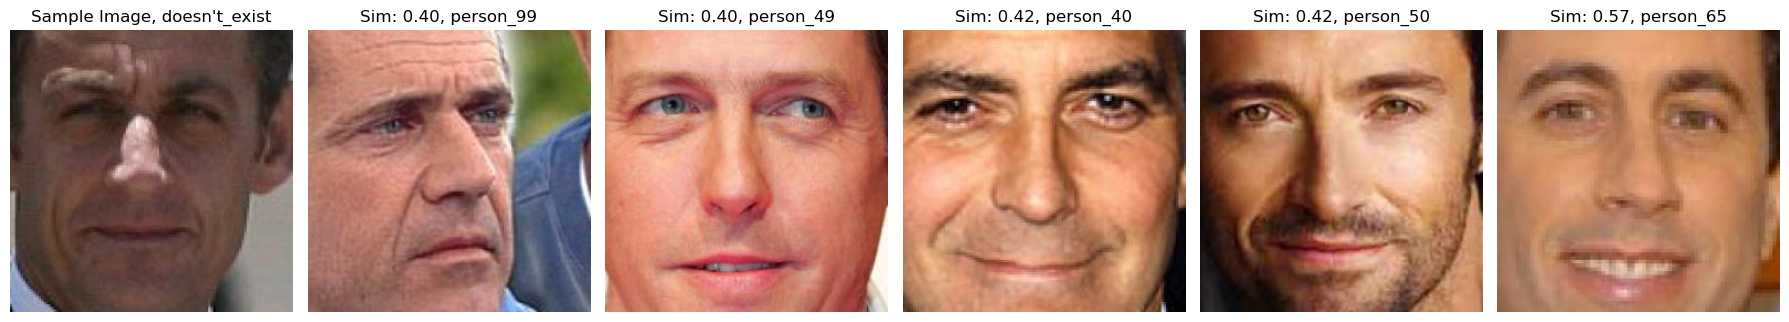

In [225]:
# r = plot_sample_top_results(val_df.iloc[24])
print(y[16], best_y_pred[16])
r = plot_sample_top_results(val_df.iloc[16])

In [ ]:
rtop = r.nlargest(10, 'cosine_similarity')
rtop.groupby('person').sum()['cosine_similarity'] / rtop['cosine_similarity'].sum()

person
person_42    1.120013
person_70    1.322188
person_78    3.579800
Name: cosine_similarity, dtype: float64

In [228]:
rtop

embeddings     person       img  \
4897  [-0.05036098, 0.013650362, -0.056891058, -0.01...  person_70  6973.jpg   
5233  [-2.0259252, 2.0779533, -0.9363154, -1.2026091...  person_78  7448.jpg   
5249  [-1.4886274, 0.8208103, -0.04927759, -0.135057...  person_78  7473.jpg   
5235  [-2.5035217, 2.2294922, -1.178092, 0.33123448,...  person_78  7450.jpg   
4896  [-0.75612015, -0.61251616, -0.6952221, 0.41229...  person_70  6972.jpg   
5243  [-1.7476165, 1.0768312, -1.4295771, -1.4198351...  person_78  7463.jpg   
5232  [-0.027853468, 0.04259435, -0.046258874, -0.02...  person_78  7446.jpg   
3313  [-0.8177481, 1.2973071, 1.2731589, -0.6742764,...  person_42  4729.jpg   
3324  [-1.1179605, 1.6723679, 0.85912263, 0.03027754...  person_42  4744.jpg   
5238  [-2.1879027, 1.0062149, -1.3029109, 0.12053492...  person_78  7453.jpg   

      cosine_similarity  
4897           0.730942  
5233           0.679679  
5249           0.599384  
5235           0.594836  
4896           0.591246  
5243           0.587850  
5232           0.566716  
3313           0.561298  
3324           0.558715  
5238           0.551334

In [ ]:
from scipy.special import softmax
from scipy.stats import entropy

probs = softmax(r['cosine_similarity'])
H = entropy(probabilities) 

AttributeError: 'Series' object has no attribute 'nlarge'

In [214]:
H

8.567558399006629

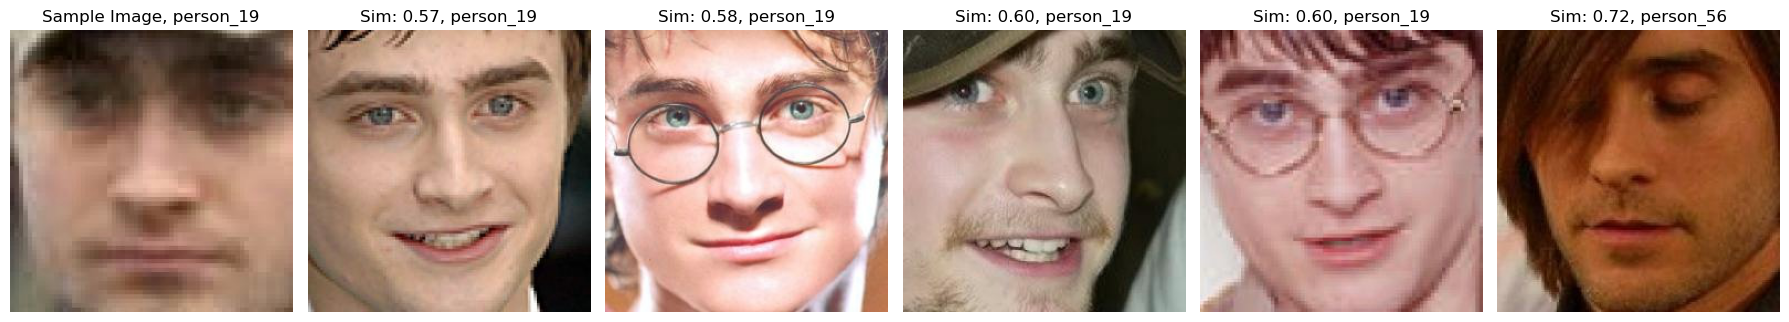

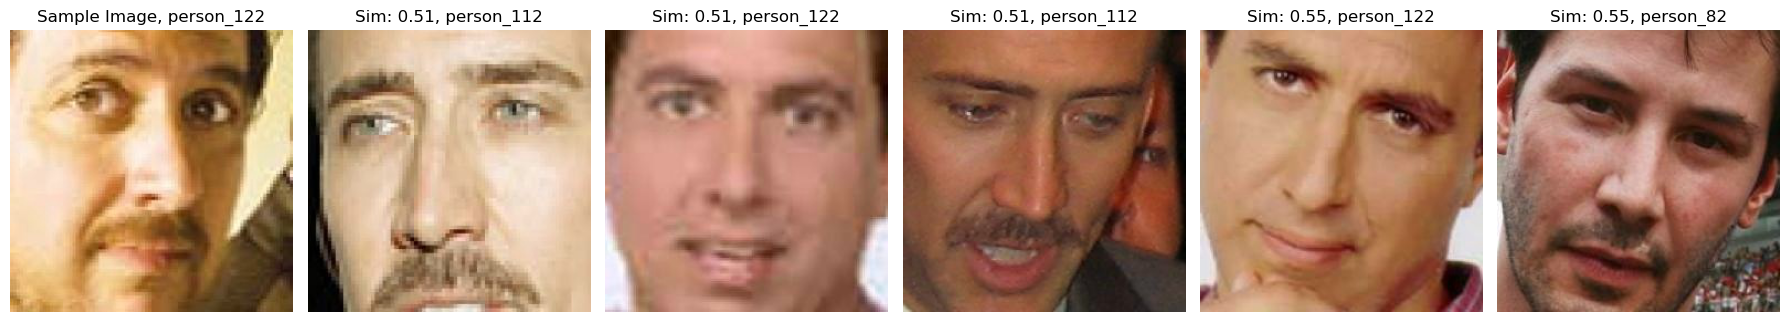

In [215]:
# 25irn m4kola tt7l :>
r = plot_sample_top_results(val_df.iloc[1372])
r = plot_sample_top_results(val_df.iloc[1376])

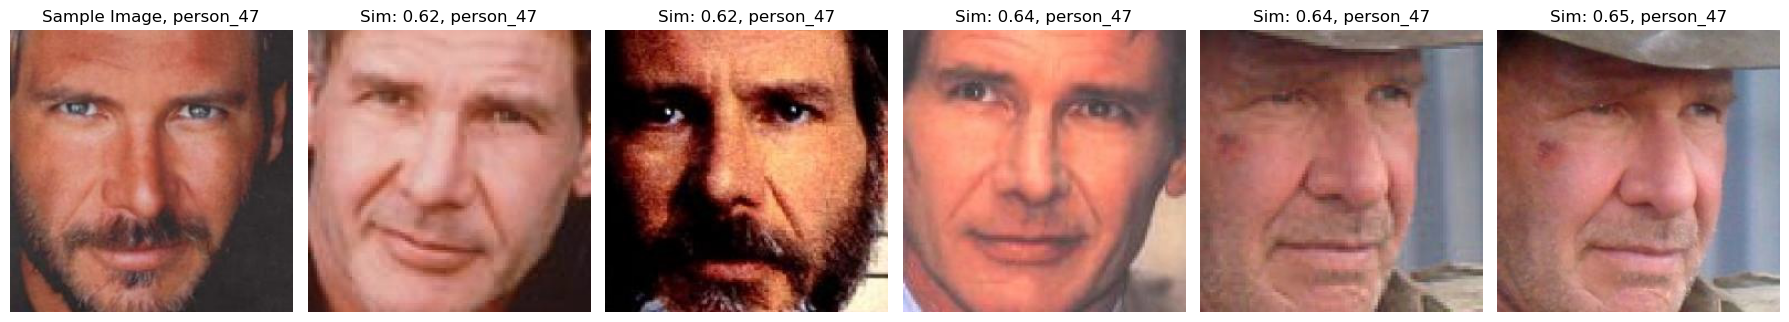

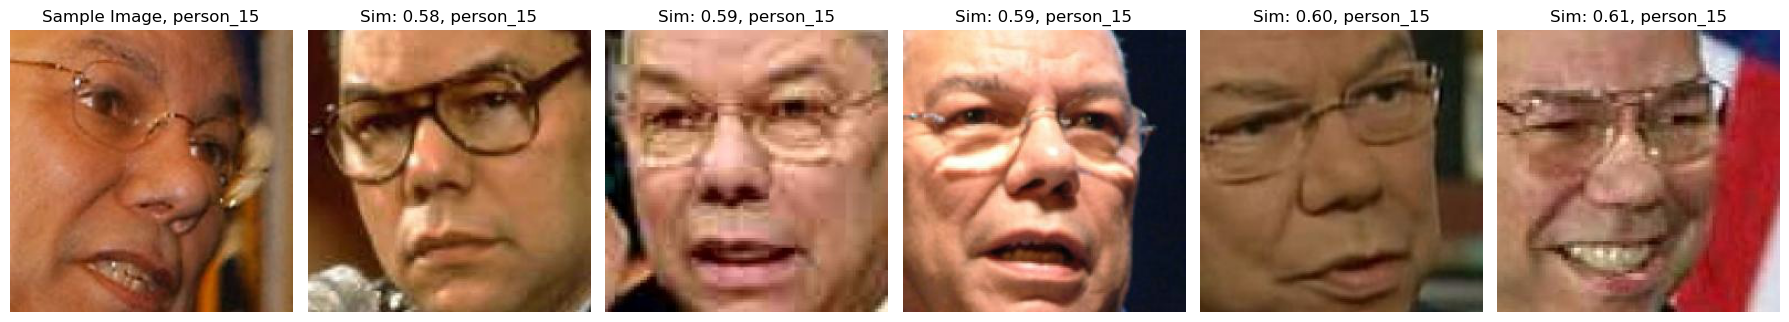

In [200]:
# threshold mistake  I think could be solved using voting
r = plot_sample_top_results(val_df.iloc[1407])
r = plot_sample_top_results(val_df.iloc[1444])

In [102]:
r[r['person'] == 'person_72']

Empty DataFrame
Columns: [embeddings, person, img, cosine_similarity]
Index: []

In [106]:
train_df[train_df['person'] == 'person_72']

Empty DataFrame
Columns: [embeddings, person, img]
Index: []